#### Import Required Libraries

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import gradio as gr

C:\Users\Acer\anaconda3\envs\tf_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Set Dataset Path and Parameters

In [2]:
DATASET_PATH = "Dataset/"  # Contains 'Cat' and 'Dog' folders
IMAGE_SIZE = (64, 64)

#### Load and Preprocess Images

In [3]:
def load_images(dataset_path):
    X, y = [], []
    for label in os.listdir(dataset_path):
        label_path = os.path.join(dataset_path, label)
        for img_file in os.listdir(label_path):
            try:
                img_path = os.path.join(label_path, img_file)
                img = cv2.imread(img_path)
                img = cv2.resize(img, IMAGE_SIZE)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                X.append(img.flatten())
                y.append(label)
            except:
                print(f"Error loading {img_path}")
    return np.array(X), np.array(y)

#### Load Data

In [4]:
X, y = load_images(DATASET_PATH)
print(f"Loaded {len(X)} images. Labels: {np.unique(y)}")

Loaded 4000 images. Labels: ['Cat' 'Dog']


#### Visualize Sample Images

In [5]:
def show_samples(X, y, label_encoder, n=5):
    plt.figure(figsize=(10, 2))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(X[i].reshape(IMAGE_SIZE), cmap='gray')
        plt.title(label_encoder.inverse_transform([y[i]])[0])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

#### Encode Labels

In [6]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

#### Train-Test Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

#### Feature Scaling

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Visualize Label Distribution

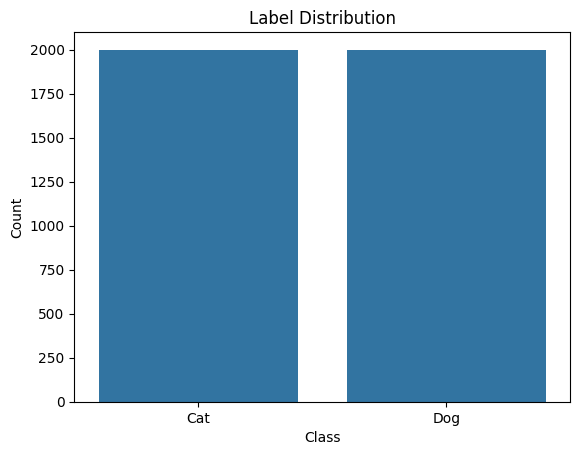

In [9]:
sns.countplot(x=le.inverse_transform(y_encoded))
plt.title("Label Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

#### Apply PCA for Visualization

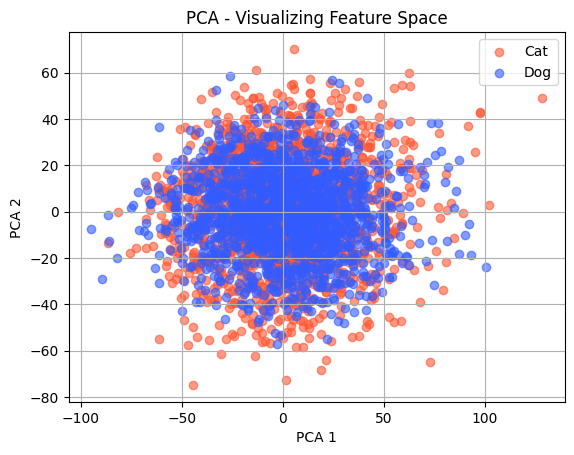

In [10]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

colors = ['#FF5733', '#335BFF']
for i, label in enumerate(np.unique(y_train)):
    plt.scatter(X_pca[y_train == label, 0], X_pca[y_train == label, 1], label=le.inverse_transform([label])[0], alpha=0.6, color=colors[i])
plt.title("PCA - Visualizing Feature Space")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.show()

#### Train SVM Model

In [11]:
svm = SVC(kernel='rbf', C=1, gamma='scale', probability=True)
svm.fit(X_train_scaled, y_train)

SVC(C=1, probability=True)

#### Evaluate on Test Set

In [12]:
y_pred = svm.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.6075
              precision    recall  f1-score   support

         Cat       0.62      0.55      0.58       400
         Dog       0.60      0.67      0.63       400

    accuracy                           0.61       800
   macro avg       0.61      0.61      0.61       800
weighted avg       0.61      0.61      0.61       800



#### Confusion Matrix

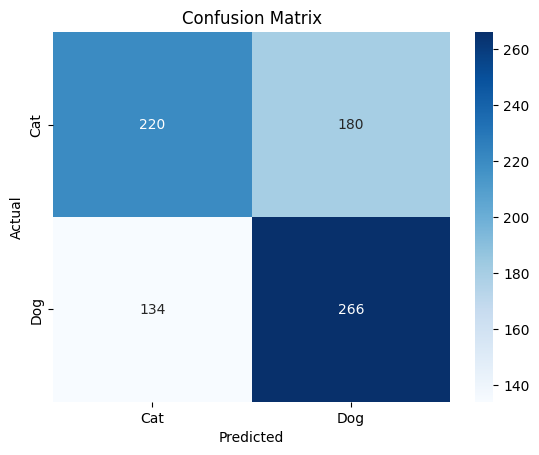

In [13]:
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#### Plot Confidence Scores

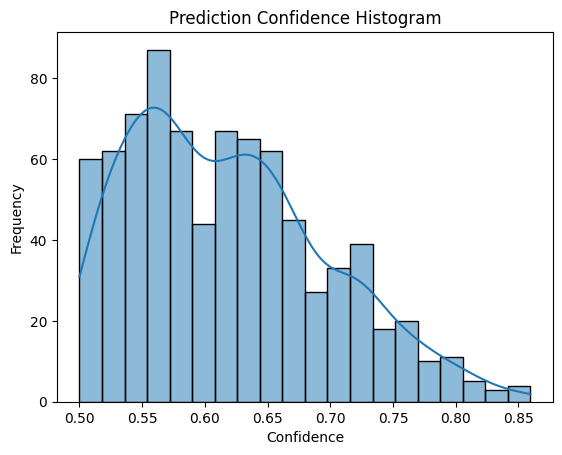

In [14]:
probs = svm.predict_proba(X_test_scaled)
confidences = np.max(probs, axis=1)

sns.histplot(confidences, bins=20, kde=True)
plt.title("Prediction Confidence Histogram")
plt.xlabel("Confidence")
plt.ylabel("Frequency")
plt.show()

#### Visualize Misclassified Images

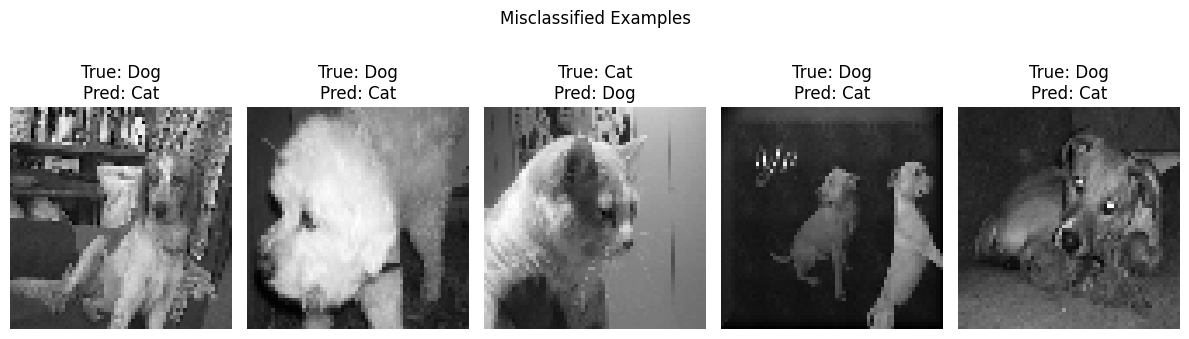

In [15]:
misclassified_idx = np.where(y_pred != y_test)[0]
plt.figure(figsize=(12, 4))
for i, idx in enumerate(misclassified_idx[:5]):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_test[idx].reshape(IMAGE_SIZE), cmap='gray')
    plt.title(f"True: {le.inverse_transform([y_test[idx]])[0]}\nPred: {le.inverse_transform([y_pred[idx]])[0]}")
    plt.axis('off')
plt.suptitle("Misclassified Examples")
plt.tight_layout()
plt.show()

#### Predict Single Image

In [16]:
def predict_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, IMAGE_SIZE)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_flat = img.flatten().reshape(1, -1)
    img_scaled = scaler.transform(img_flat)
    pred = svm.predict(img_scaled)
    label = le.inverse_transform(pred)[0]
    plt.imshow(img, cmap='gray')
    plt.title(f"Prediction: {label}")
    plt.axis('off')
    plt.show()

#### Hyperparameter Tuning (Optional)

In [17]:
params = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'], 'kernel': ['rbf', 'linear']}
grid = GridSearchCV(SVC(probability=True), params, cv=3)
grid.fit(X_train_scaled, y_train)
print("Best Parameters:", grid.best_params_)

Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


#### Save Model & Scaler

In [18]:
import joblib
joblib.dump(svm, "SVM_Model.pkl")
joblib.dump(scaler, "Scaler.pkl")
joblib.dump(le, "Label_Encoder.pkl")

['label_encoder.pkl']

#### Gradio Interface

In [19]:
def gradio_predict(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = cv2.resize(img, IMAGE_SIZE)
    img_flat = img.flatten().reshape(1, -1)
    img_scaled = scaler.transform(img_flat)
    pred = svm.predict(img_scaled)
    return le.inverse_transform(pred)[0]

gr.Interface(fn=gradio_predict, inputs="image", outputs="text", title="Cat vs Dog Classifier").launch()

Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


#### (Optional) Explore More Classifiers

In [20]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train_scaled, y_train)
print("Random Forest Accuracy:", accuracy_score(y_test, rf.predict(X_test_scaled)))

Random Forest Accuracy: 0.6025
